### **Load Libraries**

In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam


# Paths to dataset folders
BASE_PATH = "/content/drive/MyDrive/chest_xray"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH  = os.path.join(BASE_PATH, "test")

In [ ]:
# Hyperparameters
IMG_SIZE           = (224, 224)
BATCH_SIZE         = 32
EPOCHS_HEAD        = 10
EPOCHS_FINE        = 10
LEARNING_RATE      = 1e-3
LEARNING_RATE_FINE = 1e-5
UNFROZEN_LAYERS    = 10
SEED               = 123
VALIDATION_SPLIT   = 0.1

# Create data generators (using tf.data from image_dataset_from_directory)
def create_data_generators():
    # Use image_dataset_from_directory with validation_split to use 10% of TRAIN_PATH as validation
    IMAGE_SIZE = IMG_SIZE

    # Define augmentation layer
    augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(20/360),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomFlip("horizontal"),
    ])

    print('\nTraining Images:')
    train_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_PATH,
        validation_split=VALIDATION_SPLIT,
        subset='training',
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    # Apply augmentation to training set
    def augment_images(x, y):
        return augmentation(x, training=True), y

    print('\nValidation Images:')
    val_ds = tf.keras.utils.image_dataset_from_directory(
        TRAIN_PATH,
        validation_split=VALIDATION_SPLIT,
        subset='validation',
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    print('\nTesting Images:')
    test_ds = tf.keras.utils.image_dataset_from_directory(
        TEST_PATH,
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    # Normalize pixel values to [0,1] and cast labels to float32 (binary)
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.map(augment_images, num_parallel_calls=AUTOTUNE)
    train_ds = train_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.float32)),
                            num_parallel_calls=AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.float32)),
                        num_parallel_calls=AUTOTUNE)
    test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.float32)),
                          num_parallel_calls=AUTOTUNE)

    # Prefetch for performance
    train_ds = train_ds.prefetch(AUTOTUNE)
    val_ds = val_ds.prefetch(AUTOTUNE)
    test_ds = test_ds.prefetch(AUTOTUNE)

    # Return datasets
    return train_ds, val_ds, test_ds

In [ ]:
model, base_model = build_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 49,278,337 (187.98 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

#### **Build Model & Train Model**

TensorFlow version: 2.19.0

Training Images:
Found 5232 files belonging to 2 classes.
Using 4709 files for training.

Validation Images:
Found 5232 files belonging to 2 classes.
Using 523 files for validation.

Testing Images:
Found 624 files belonging to 2 classes.
Class names (fallback): ['NORMAL', 'PNEUMONIA']
Class weights: {0: np.float64(1.9236111111111112), 1: np.float64(0.675609756097561)}

[INFO] Training only the head layers...
Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1463s 10s/step - accuracy: 0.5289 - loss: 2.1510 - val_accuracy: 1.0000 - val_loss: 0.5654
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1428s 10s/step - accuracy: 0.7452 - loss: 0.6930 - val_accuracy: 1.0000 - val_loss: 0.6888
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1413s 10s/step - accuracy: 0.7432 - loss: 0.6865 - val_accuracy: 1.0000 - val_loss: 0.6920
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1415s 10s/step - accuracy: 0.7280 - loss: 0.6860 - val_accuracy: 1.0000 - val_loss: 0.6927
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━

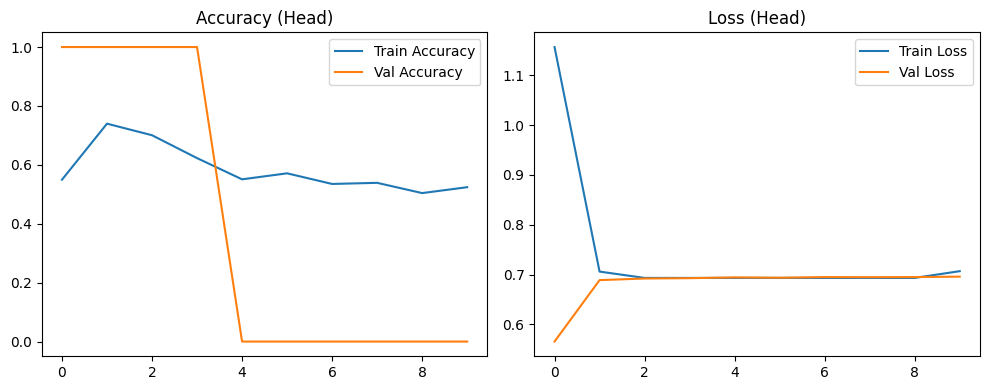


[INFO] Fine-tuning last 30 layers of ResNet50...
Epoch 1/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1907s 13s/step - accuracy: 0.8254 - loss: 0.3689 - val_accuracy: 0.4761 - val_loss: 0.7270
Epoch 2/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1932s 13s/step - accuracy: 0.9030 - loss: 0.2303 - val_accuracy: 0.9140 - val_loss: 0.2703
Epoch 3/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1949s 13s/step - accuracy: 0.9202 - loss: 0.2087 - val_accuracy: 0.9866 - val_loss: 0.0250
Epoch 4/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1968s 13s/step - accuracy: 0.9325 - loss: 0.1687 - val_accuracy: 0.8872 - val_loss: 0.2973
Epoch 5/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1979s 13s/step - accuracy: 0.9303 - loss: 0.1730 - val_accuracy: 0.9579 - val_loss: 0.0875
Epoch 6/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1941s 13s/step - accuracy: 0.9351 - loss: 0.1708 - val_accuracy: 0.9771 - val_loss: 0.0580
Epoch 7/10
148/148 ━━━━━━━━━━━━━━━━━━━━ 1959s 13s/step - accuracy: 0.9398 - loss: 0.1725 - val_accuracy: 0.9446 - val_loss: 0.1213
Epoch 8/10
148/148 ━━━━━━━━━━━━━━

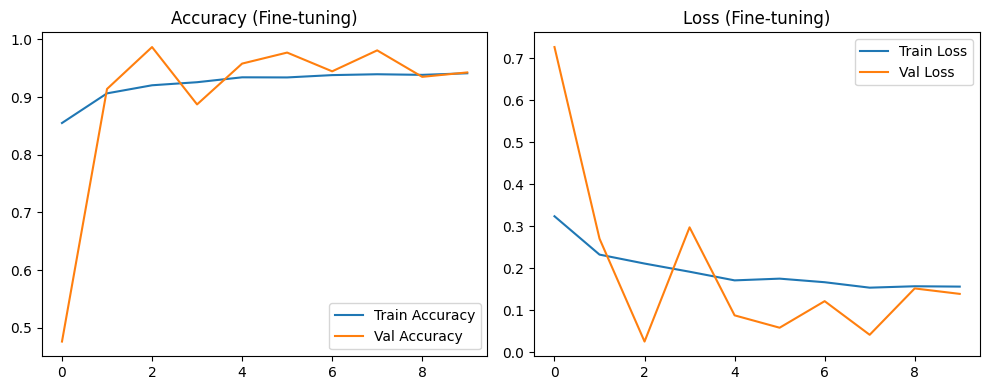


[INFO] Evaluating on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 166s 8s/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.68      0.80       234
   PNEUMONIA       0.84      0.98      0.90       390

    accuracy                           0.87       624
   macro avg       0.90      0.83      0.85       624
weighted avg       0.88      0.87      0.86       624



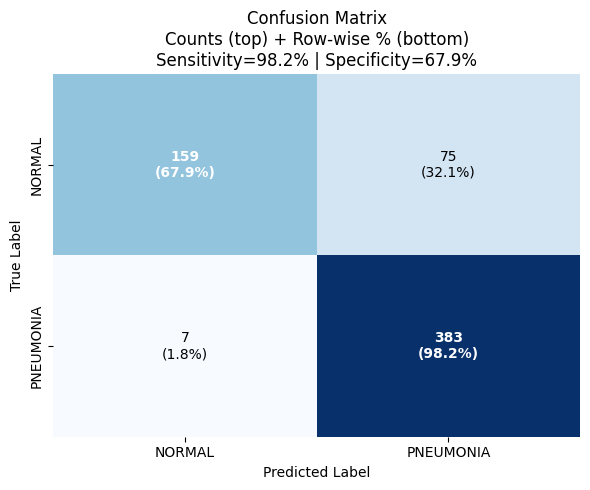

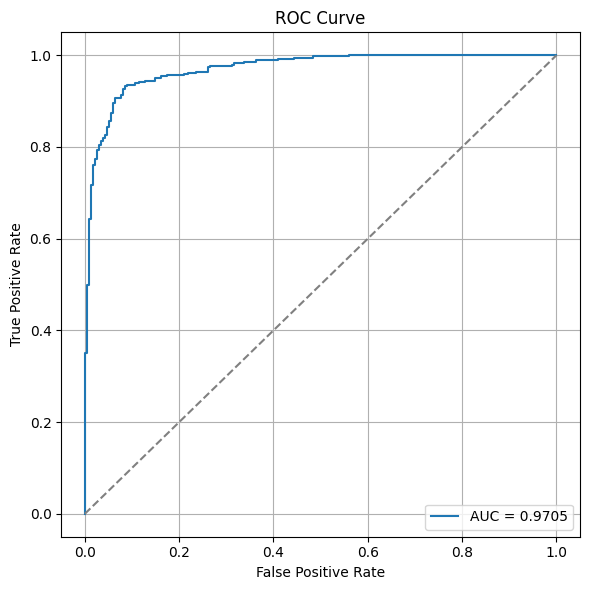


[INFO] Saved model to: /content/drive/MyDrive/chest_xray/Pneumo_Resnet50_model.keras


In [ ]:
# -------------------------------------------------------------------------
# Build the model & return the base_model for fine-tuning
# -------------------------------------------------------------------------
def build_model():
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
    )
    # Freeze all layers of ResNet
    for layer in base_model.layers:
        layer.trainable = False

    # Add our "head" on top
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    preds = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs=base_model.input, outputs=preds)
    return model, base_model

# -------------------------------------------------------------------------
# Plot training history (accuracy & loss)
# -------------------------------------------------------------------------
def plot_history(history, title_suffix=""):
    acc = history.history.get('accuracy', [])
    val_acc = history.history.get('val_accuracy', [])
    loss = history.history.get('loss', [])
    val_loss = history.history.get('val_loss', [])

    epochs_range = range(len(acc))

    plt.figure(figsize=(10, 4))
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.title(f'Accuracy {title_suffix}')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'Loss {title_suffix}')
    plt.legend()

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------------
# Train only the head
# -------------------------------------------------------------------------
def train_head(model, train_gen, val_gen, class_weights):
    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print("\n[INFO] Training only the head layers...")
    history = model.fit(
        train_gen,
        epochs=EPOCHS_HEAD,
        validation_data=val_gen,
        class_weight=class_weights
    )
    return history

# -------------------------------------------------------------------------
# Fine-tune the last UNFROZEN_LAYERS of the base_model
# -------------------------------------------------------------------------
def fine_tune(model, base_model, train_gen, val_gen, class_weights):
    total_layers = len(base_model.layers)
    # Unfreeze the last 'UNFROZEN_LAYERS'
    for layer in base_model.layers[total_layers - UNFROZEN_LAYERS:]:
        layer.trainable = True

    model.compile(
        optimizer=Adam(learning_rate=LEARNING_RATE_FINE),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    print(f"\n[INFO] Fine-tuning last {UNFROZEN_LAYERS} layers of ResNet50...")
    history = model.fit(
        train_gen,
        epochs=EPOCHS_FINE,
        validation_data=val_gen,
        #class_weight=class_weights
    )
    return history

# -------------------------------------------------------------------------
# Enhanced evaluation with improved confusion matrix and ROC curve
# -------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

def evaluate_model(model, test_gen, class_names):
    print("\n[INFO] Evaluating on test set...")

    # Get predictions
    y_true = np.concatenate([y for x, y in test_gen], axis=0)
    y_probs = model.predict(test_gen, verbose=1).ravel()
    y_pred = (y_probs > 0.5).astype(int) # Using 0.5 threshold for this evaluation in the main training loop

    # Get class names
    # class_names is now passed as an argument

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Enhanced confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    row_totals = cm.sum(axis=1)
    cm_percent = (cm.astype('float') / row_totals[:, np.newaxis]) * 100

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names,
                    cbar=False)

    # Add annotations with counts and percentages
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            is_correct = (i == j)
            text = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"
            ax.text(j + 0.5, i + 0.5, text,
                   ha='center', va='center',
                   color='white' if is_correct else 'black',
                   weight='bold' if is_correct else 'normal')

    # Calculate clinical metrics
    sensitivity = cm[1,1]/row_totals[1]*100
    specificity = cm[0,0]/row_totals[0]*100

    plt.title(f"Confusion Matrix\nCounts (top) + Row-wise % (bottom)\nSensitivity={sensitivity:.1f}% | Specificity={specificity:.1f}%")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # ROC Curve
    auc_score = roc_auc_score(y_true, y_probs)
    fpr, tpr, _ = roc_curve(y_true, y_probs)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------------------
# Main
# -------------------------------------------------------------------------
def main():

    # Enable GPU memory growth
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    print("TensorFlow version:", tf.__version__)

    # Create data generators (now tf.data datasets with 10% validation split)
    train_gen, val_gen, test_gen = create_data_generators()

    # Print class names for confirmation
    try:
        class_names = train_gen.class_names
        print("Class names:", class_names)
    except Exception:
        # If dataset is a tf.data.Dataset, get class names from a directory listing fallback
        class_names = sorted([d for d in os.listdir(TRAIN_PATH) if os.path.isdir(os.path.join(TRAIN_PATH, d))])
        print("Class names (fallback):", class_names)

    # Calculate class weights
    import numpy as np
    from sklearn.utils.class_weight import compute_class_weight

    # Get the true labels from the training dataset
    train_labels = np.concatenate([y.numpy() for x, y in train_gen], axis=0)

    # Calculate class weights
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights = {i: weight for i, weight in enumerate(class_weights)}


    # Build model (and get base_model ref)
    model, base_model = build_model()

    # Train the head
    history_head = train_head(model, train_gen, val_gen, class_weights)
    plot_history(history_head, "(Head)")

    # Fine-tune
    history_fine = fine_tune(model, base_model, train_gen, val_gen, class_weights)
    plot_history(history_fine, "(Fine-tuning)")

    # Evaluate
    evaluate_model(model, test_gen, class_names)

    # Save the model
    save_path = os.path.join(BASE_PATH, "Pneumo_Resnet50_model.keras")
    model.save(save_path)
    print(f"\n[INFO] Saved model to: {save_path}")

if __name__ == "__main__":
    main()

### **Evaluation**

Found 624 files belonging to 2 classes.

[INFO] Evaluating on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step - accuracy: 0.7650 - loss: 0.4966
Test Loss: 0.2981
Test Accuracy: 0.8686
20/20 ━━━━━━━━━━━━━━━━━━━━ 123s 6s/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9578    0.6795    0.7950       234
   PNEUMONIA     0.8362    0.9821    0.9033       390

    accuracy                         0.8686       624
   macro avg     0.8970    0.8308    0.8492       624
weighted avg     0.8818    0.8686    0.8627       624



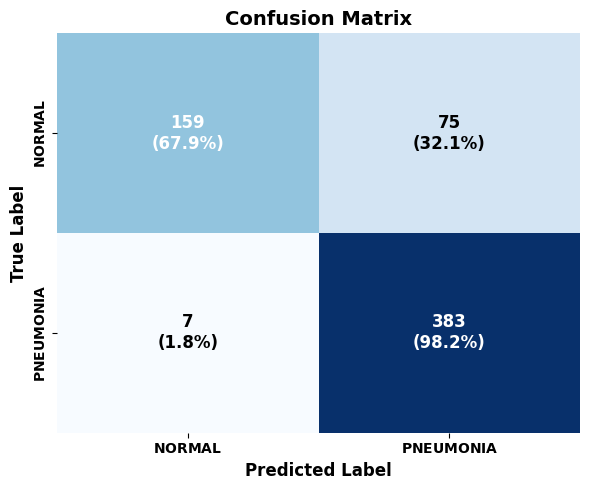

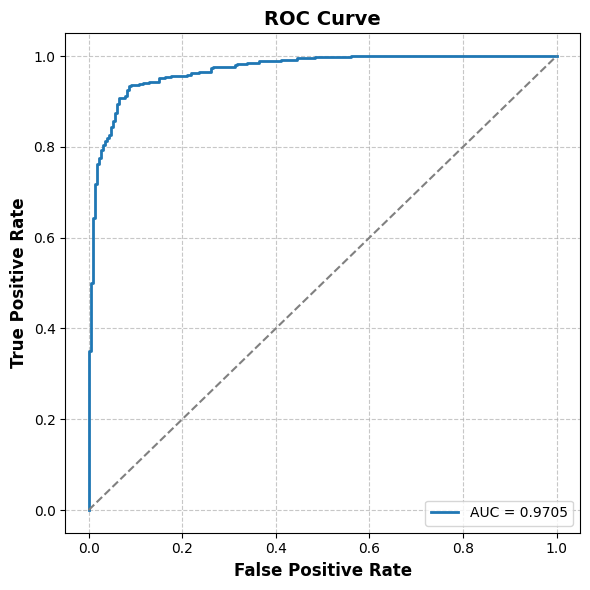

In [ ]:
# Evaluate a trained ResNet50 model: classification report, AUROC, confusion matrix
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.models import load_model


# Paths
BASE_PATH = "/content/drive/MyDrive/chest_xray"
TEST_PATH = os.path.join(BASE_PATH, "test")
MODEL_PATH = os.path.join(BASE_PATH, "Pneumo_Resnet50_model.keras")

# Load the trained model
model = load_model(MODEL_PATH)

# Load the test dataset
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = test_ds.class_names

# Normalize to [0,1]
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.float32)))

# Get predictions and evaluate loss
print("\n[INFO] Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_probs = model.predict(test_ds, verbose=1).ravel()
# Use the chosen threshold (0.50) for classification
y_pred = (y_probs > 0.50).astype(int)


# Classification report
print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))


# Confusion matrix with percentage annotations and bold labels
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=[f"$\\bf{{{name}}}$" for name in class_names],
            yticklabels=[f"$\\bf{{{name}}}$" for name in class_names],
            cbar=False)

# Annotate with counts and percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        is_true_positive = (i == j)
        text = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"
        color = "white" if is_true_positive else "black"
        weight = "bold"
        plt.text(j + 0.5, i + 0.5,
                 text,
                 ha="center", va="center",
                 color=color, fontsize=12, fontweight=weight)

plt.title("Confusion Matrix", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Label", fontsize=12, fontweight="bold")
plt.ylabel("True Label", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()

# Compute AUROC and plot ROC curve
auc_score = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve", fontsize=14, fontweight="bold")
plt.xlabel("False Positive Rate", fontsize=12, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=12, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

#### **Model Size**

In [ ]:
import os

model_path = "/content/drive/MyDrive/chest_xray/Pneumo_Resnet50_model.keras"
model_size_bytes = os.path.getsize(model_path)
model_size_mb = model_size_bytes / (1024 * 1024)

print(f"Model size: {model_size_mb:.2f} MB")

Model size: 494.88 MB


#### **Just Experimenting Different Thresholds (Optional)**

Found 624 files belonging to 2 classes.

[INFO] Evaluating on test set...
20/20 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - accuracy: 0.7650 - loss: 0.4966
Test Loss: 0.2981
Test Accuracy: 0.8686
20/20 ━━━━━━━━━━━━━━━━━━━━ 125s 6s/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.7690    0.9530    0.8511       234
   PNEUMONIA     0.9671    0.8282    0.8923       390

    accuracy                         0.8750       624
   macro avg     0.8680    0.8906    0.8717       624
weighted avg     0.8928    0.8750    0.8768       624



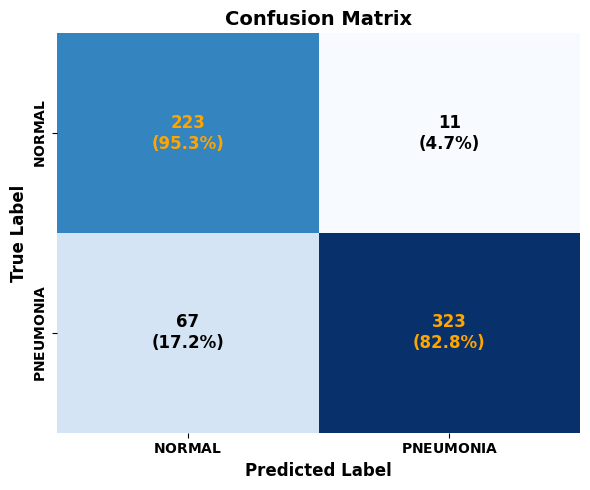

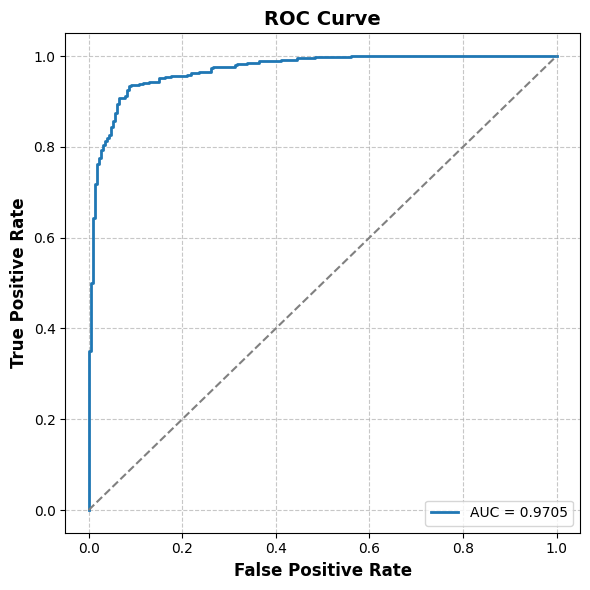

In [ ]:
# Evaluate a trained ResNet50 model: classification report, AUROC, confusion matrix
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from tensorflow.keras.models import load_model

# Paths
BASE_PATH = "/content/drive/MyDrive/chest_xray"
TEST_PATH = os.path.join(BASE_PATH, "test")
MODEL_PATH = os.path.join(BASE_PATH, "Pneumo_Resnet50_model.keras")

# Load the trained model
model = load_model(MODEL_PATH)

# Load the test dataset
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = test_ds.class_names

# Normalize to [0,1]
test_ds = test_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, tf.cast(y, tf.float32)))


# Get predictions and evaluate loss
print("\n[INFO] Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
y_probs = model.predict(test_ds, verbose=1).ravel()

# Use the chosen threshold (0.95) for classification
y_pred = (y_probs > 0.95).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))

# Confusion matrix with percentage annotations and bold labels
cm = confusion_matrix(y_true, y_pred)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=False, cmap='Blues',
            xticklabels=[f"$\\bf{{{name}}}$" for name in class_names],
            yticklabels=[f"$\\bf{{{name}}}$" for name in class_names],
            cbar=False)

# Annotate with counts and percentages
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        is_true_positive = (i == j)
        text = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"
        color = "orange" if is_true_positive else "black"
        weight = "bold"
        plt.text(j + 0.5, i + 0.5,
                 text,
                 ha="center", va="center",
                 color=color, fontsize=12, fontweight=weight)

plt.title("Confusion Matrix", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Label", fontsize=12, fontweight="bold")
plt.ylabel("True Label", fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()


# Compute AUROC and plot ROC curve
auc_score = roc_auc_score(y_true, y_probs)
fpr, tpr, _ = roc_curve(y_true, y_probs)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve", fontsize=14, fontweight="bold")
plt.xlabel("False Positive Rate", fontsize=12, fontweight="bold")
plt.ylabel("True Positive Rate", fontsize=12, fontweight="bold")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# -------------------------------------------------------------------------
# Find optimal threshold
# -------------------------------------------------------------------------
import pandas as pd
thresholds = np.arange(0.1, 1.0, 0.05)  # Iterate through thresholds from 0.1 to 0.95
results = []

print("Evaluating model performance for different thresholds...")
for t in thresholds:
    y_pred_threshold = (y_probs > t).astype(int)
    report = classification_report(y_true, y_pred_threshold, target_names=class_names, output_dict=True)
    results.append({
        'threshold': t,
        'normal_precision': report['NORMAL']['precision'],
        'normal_recall': report['NORMAL']['recall'],
        'normal_f1': report['NORMAL']['f1-score'],
        'pneumonia_precision': report['PNEUMONIA']['precision'],
        'pneumonia_recall': report['PNEUMONIA']['recall'],
        'pneumonia_f1': report['PNEUMONIA']['f1-score'],
        'accuracy': report['accuracy']
    })

results_df = pd.DataFrame(results)
display(results_df)

Evaluating model performance for different thresholds...


,threshold,normal_precision,normal_recall,normal_f1,pneumonia_precision,pneumonia_recall,pneumonia_f1,accuracy
0,0.10,1.000000,0.414530,0.586103,0.740038,1.000000,0.850600,0.780449
1,0.15,0.990826,0.461538,0.629738,0.755340,0.997436,0.859669,0.796474
2,0.20,0.991667,0.508547,0.672316,0.771825,0.997436,0.870246,0.814103
3,0.25,0.984496,0.542735,0.699725,0.783838,0.994872,0.876836,0.825321
4,0.30,0.977941,0.568376,0.718919,0.793033,0.992308,0.881549,0.833333
5,0.35,0.978723,0.589744,0.736000,0.801242,0.992308,0.886598,0.841346
6,0.40,0.972973,0.615385,0.753927,0.810924,0.989744,0.891455,0.849359
7,0.45,0.967532,0.636752,0.768041,0.819149,0.987179,0.895349,0.855769
8,0.50,0.957831,0.679487,0.795000,0.836245,0.982051,0.903302,0.868590
9,0.55,0.947059,0.688034,0.797030,0.839207,0.976923,0.902844,0.868590
